# Web of Science - Word mover distance analysis

### Load wos_econ, wos_soc


In [28]:
import sys
sys.path.append("./../helper") # find scripts
maxInt = sys.maxsize

from common_imports import *
from helpers import *

#from load_data import wos_soc, wos_econ   # web of science
from load_constellate import wos_soc, wos_econ # constellate

import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin.gz', binary=True)

model.init_sims(replace=True) 

import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Create Dataframes

In [72]:
df_econ = pd.DataFrame.from_dict(wos_econ)
df_soc = pd.DataFrame.from_dict(wos_soc)

### 3 functions to create do  the word mover distance analysis

In [193]:
import random

def crCorpus(df, y1=None, y2=None, smax=None, term=None):
    
    """
    Subset the corpuses by year and term
    """
    
    # Subfunction to flatten list
    def flatten(t):
        return [item for sublist in t for item in sublist]

    # Subset by year
    if y1 is not None: 
        if y2 is None: y2 = y1 
        df = df[df['year'].between(y1, y2)] 
    
    # Subset by term
    if term is not None: df = df[df['title'].str.contains(term)]
        
    # Sample from df if larger than smax
    if smax is not None: 
        if df.shape[0]>smax: df = df.sample(n=smax, replace=False, random_state=1)

    # Create corpus
    words = flatten(df['title'].str.split().tolist())
    
    unique = []
    for word in words:
        if word not in unique:
            unique.append(word)
    unique.sort()
            
    return(unique)


def crWMD(t0, t1, iv=1, smax=None, term=None):
    
    """
    Calculates the WMD distances over time
    """
    
    # Calculate distance by year
    
    wmd  = [] # save mover distance
    istart = 1900 # starting year
    
    while istart <= (2020-iv):
        
        iend = istart+iv
        
        if istart==1900: print("...")
        if istart>1980:  print("Start: "+str(istart)+", End:"+str(iend))
        
        t0_corp = crCorpus(t0, y1=istart, y2=iend, smax=smax, term=term)
        t1_corp = crCorpus(t1, y1=istart+iv, y2=iend+iv, smax=smax, term=term)
        
        wmd.append(model.wmdistance(t0_corp, t1_corp))
        
        istart+=iv
    
    return wmd


def plotWMD(iv=1, smax=100, term=None, autosim=False):
    
    """
    Plot the WMD over time
    """
    
    # Calculate distances
    print("soc@t to econ@t+1")
    wmd1 = crWMD(t0=df_soc, t1=df_econ, iv=iv, smax=smax, term=term)
    
    print("econ@t to soc@t+1")
    wmd2 = crWMD(t0=df_econ, t1=df_soc, iv=iv, smax=smax, term=term)
    
    if autosim is not False: 
        print("soc@t to soc@t+1")
        wmd3 = crWMD(t0=df_soc, t1=df_soc, iv=iv, smax=smax, term=term)
        
        print("econ@t to econ@t+1")
        wmd4 = crWMD(t0=df_econ, t1=df_econ, iv=iv, smax=smax, term=term)
    
    # Plot results  
    
    yrs=list(range(1900,2020,iv))
        
    p = plt.plot(yrs, wmd1, label="soc@t to econ@t+1");
    p = plt.plot(yrs, wmd2, label="econ@t to soc@t+1");
    
    if autosim is not False:
        p = plt.plot(yrs, wmd3, label="soc@t to soc@t+1");
        p = plt.plot(yrs, wmd4, label="econ@t to econ@t+1");
        
    p = plt.title("Term: "+str(term))
    p = plt.legend()

### Results
- iv: Control the intervals from 1900 to 2020
- smax: Number of articles taken from each interval in each discipline
- term: Pick a specific term which has to be included in all articles. If None, all articles are chosen.
- autosim: Should soc@t to soc@t+1 and econ@t to econ@t+1 also be computed?

soc@t to econ@t+1
...
Start: 1990, End:2000
Start: 2000, End:2010
Start: 2010, End:2020
econ@t to soc@t+1
...
Start: 1990, End:2000
Start: 2000, End:2010
Start: 2010, End:2020


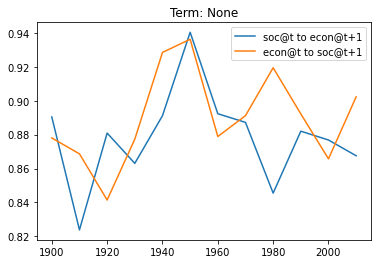

In [194]:
plotWMD(iv=10, smax=100, autosim=False)